# A Introduction to GANs (We will cover DCGANs)

We will be covering Deep Convolutional GANs in this notebook. We will work with the MNIST Dataset for this recitation. Everyone can try to apply a similar architecture for other datasets such as Celeb-A, etc.

## Import All The Necessary Libraries

In [ ]:
# Import necessary libraries
import os
import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from matplotlib.pyplot import imshow, imsave

# Set the device: GPU if available, otherwise CPU
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print device for debugging
print(f"Using device: {DEVICE}")

Using device: cuda:0


## Create a Discriminator Model

The Discriminator in a GAN (Generative Adversarial Network) is a neural network that acts as a binary classifier, distinguishing between real data samples and fake data generated by the Generator.

 The Discriminator provides a gradient signal to the Generator, enabling it to improve and produce more realistic outputs over time.

 The Discriminator tries to minimize the Binary Cross-Entropy (BCE) loss between its predictions and the true labels (1 for real, 0 for fake).
It competes with the Generator, which aims to maximize the Discriminator’s error.


## Structure of the Discriminator
Takes the image or data sample as input. For MNIST, the input size is typically
28×28 grayscale images and converts the input into a feature map using convolutional layers. The Discriminator often uses convolutional layers to extract spatial features from images. These layers are followed by Batch Normalization to stabilize learning and accelerate convergence. The Leaky ReLU Activation is used to allow small gradients for negative inputs, preventing dead neurons. Downsampling is applied via pooling or strides in convolution layers to progressively reduce the spatial dimensions of the input. Finally,  Fully Connected Layers is used after the convolutional layers, the feature map is flattened and passed through one or more fully connected layers. The model outputs a single value (probability) using a Sigmoid activation function.

In [ ]:
class Discriminator(nn.Module):
    """
    Convolutional Discriminator for MNIST.

    Args:
        in_channel (int): Number of input channels (default is 1 for grayscale images like MNIST).
        num_classes (int): Number of output classes (default is 1 for binary classification).
    """
    def __init__(self, in_channel=1, num_classes=1):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            # Input: (in_channel, 28, 28), Output: (512, 14, 14)
            nn.Conv2d(in_channel, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Input: (512, 14, 14), Output: (256, 7, 7)
            nn.Conv2d(512, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Input: (256, 7, 7), Output: (128, 4, 4)
            nn.Conv2d(256, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Global pooling: (128, 4, 4) -> (128, 1, 1)
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Sequential(
            # Fully connected layer: Input (128,) -> Output (num_classes,)
            nn.Linear(128, num_classes),
            nn.Sigmoid(),  # Suitable for binary classification
        )

    def forward(self, x, y=None):
        """
        Forward pass of the Discriminator.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_channel, height, width).
            y (torch.Tensor, optional): Not used but kept for compatibility with conditional setups.

        Returns:
            torch.Tensor: Output predictions of shape (batch_size, num_classes).
        """
        y_ = self.conv(x)  # Apply convolutional layers
        y_ = y_.view(y_.size(0), -1)  # Flatten for fully connected layers
        y_ = self.fc(y_)  # Apply fully connected layers
        return y_

## Create a Generator Model

The Generator in a GAN (Generative Adversarial Network) is a neural network that generates fake data samples, such as images, aiming to mimic the real data distribution.

The Generator takes random noise as input and transforms it into structured outputs (e.g., images) that resemble real samples from the dataset. The Generator improves over time by receiving gradient signals from the Discriminator, which evaluates how realistic the generated samples are.

The Generator’s objective is to maximize the Discriminator's error, effectively "fooling" the Discriminator into classifying fake samples as real.

## Structure of the Generator
The Generator transforms random noise into meaningful data through a series of layers designed to progressively refine the output. It begins with a noise vector, typically sampled from a standard normal distribution (N(0,1)), which serves as the input. This noise vector is passed through fully connected layers to project it into a higher-dimensional representation, creating a low-resolution feature map. The Generator then uses transposed convolutional layers (also known as deconvolutions) to upsample this feature map, gradually increasing its spatial dimensions. Batch Normalization is applied after each layer to stabilize learning and accelerate convergence, while ReLU activations ensure non-linearity in the intermediate layers. Finally, the Generator outputs the data in the desired shape (e.g., a 28×28 image for MNIST) using a Tanh activation function, which normalizes the output values to the range [−1,1]. This output range matches the normalization of the real data, ensuring effective training with the Discriminator.

In [ ]:
class Generator(nn.Module):
    """
    Convolutional Generator for MNIST.

    Args:
        input_size (int): The size of the noise vector (default is 100).
        num_classes (int): The flattened size of the output image (default is 784 for 28x28 images).
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            # Fully connected layer: Input (input_size,) -> Output (4*4*512,)
            nn.Linear(input_size, 4 * 4 * 512),
            nn.ReLU(inplace=True),
        )
        self.conv = nn.Sequential(
            # Input: (512, 4, 4), Output: (256, 7, 7)
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # Input: (256, 7, 7), Output: (128, 14, 14)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Input: (128, 14, 14), Output: (1, 28, 28)
            nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),  # Output pixel values are normalized to [-1, 1]
        )

    def forward(self, x, y=None):
        """
        Forward pass of the Generator.

        Args:
            x (torch.Tensor): Input noise tensor of shape (batch_size, input_size).
            y (torch.Tensor, optional): Not used but kept for compatibility with conditional setups.

        Returns:
            torch.Tensor: Generated images of shape (batch_size, 1, 28, 28).
        """
        # Flatten input noise and pass through fully connected layers
        x = x.view(x.size(0), -1)
        y_ = self.fc(x)

        # Reshape to match convolutional input dimensions
        y_ = y_.view(y_.size(0), 512, 4, 4)

        # Apply transpose convolutions to generate an image
        y_ = self.conv(y_)
        return y_


## Initialize your models and apply transforms if Necessary

In [ ]:
# Initialize the Discriminator and Generator models
D = Discriminator().to(DEVICE)  # Send the Discriminator to the specified device
G = Generator().to(DEVICE)      # Send the Generator to the specified device

# Define the data transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL images or numpy arrays to tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1] (GAN-friendly range)
])


## Dataset and Dataloader

Working with the MNIST Dataset (Fairly Straight Forward)

In [ ]:
# Download and prepare the MNIST dataset
mnist = datasets.MNIST(
    root='../data/',          # Path to save the dataset
    train=True,               # Load the training dataset
    transform=transform,      # Apply the defined transformations
    download=True             # Download the dataset if not already available
)

# Create a DataLoader for batching and shuffling the dataset
data_loader = DataLoader(
    dataset=mnist,            # Pass the MNIST dataset
    batch_size=64,            # Number of samples per batch
    shuffle=True,             # Shuffle the dataset for training
    drop_last=True            # Drop the last incomplete batch
)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.5MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.1MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## Initialize your criterion and Optimizer for both Generator and Discriminator

In [ ]:
# Binary Cross-Entropy Loss for real vs. fake classification
criterion = nn.BCELoss()

# Optimizer for the Discriminator
D_opt = torch.optim.Adam(
    D.parameters(),           # Parameters to optimize
    lr=0.001,                 # Learning rate
    betas=(0.5, 0.999)        # Beta values for Adam optimizer
)

# Optimizer for the Generator
G_opt = torch.optim.Adam(
    G.parameters(),           # Parameters to optimize
    lr=0.001,                 # Learning rate
    betas=(0.5, 0.999)        # Beta values for Adam optimizer
)


## Training Config

In [ ]:
# Training Configuration
max_epoch = 30        # Total number of training epochs
step = 0              # Initialize step counter for logging and monitoring
n_critic = 1          # Number of Discriminator training steps per Generator step
n_noise = 100         # Size of the input noise vector for the Generator


## Labels

In [ ]:
# Labels for the Discriminator
batch_size = 64  # Batch size for training

D_labels = torch.ones((batch_size, 1), device=DEVICE)  # Real labels (1)
D_fakes = torch.zeros((batch_size, 1), device=DEVICE)  # Fake labels (0)

## The Fun Stuff where everything comes together. Lets Train some GANs

In [ ]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        # Transfer images to the specified device
        x = images.to(DEVICE)

        # ---------------------
        # Train Discriminator
        # ---------------------
        # Real images loss
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels[:x.size(0)])  # Adjust labels for last batch

        # Fake images loss
        z = torch.randn(x.size(0), n_noise, device=DEVICE)  # Match batch size dynamically
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes[:x.size(0)])  # Adjust labels for last batch

        # Total Discriminator loss
        D_loss = D_x_loss + D_z_loss

        # Backpropagation and optimization
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # ---------------------
        # Train Generator
        # ---------------------
        if step % n_critic == 0:
            z = torch.randn(x.size(0), n_noise, device=DEVICE)  # Match batch size dynamically
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels[:x.size(0)])  # Generator tries to fool Discriminator

            # Backpropagation and optimization
            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        # ---------------------
        # Logging and Evaluation
        # ---------------------
        if step % 500 == 0:
            print(f"Epoch: {epoch}/{max_epoch}, Step: {step}, D Loss: {D_loss.item():.4f}, G Loss: {G_loss.item():.4f}")

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            os.makedirs('samples', exist_ok=True)  # Ensure the samples directory exists
            imsave(f'samples/DCGAN_step{str(step).zfill(3)}.jpg', img, cmap='gray')
            G.train()

        # Increment the step counter
        step += 1

Epoch: 0/30, Step: 0, D Loss: 1.3896, G Loss: 0.7293
Epoch: 0/30, Step: 500, D Loss: 0.5944, G Loss: 1.4816
Epoch: 1/30, Step: 1000, D Loss: 0.4654, G Loss: 2.1538
Epoch: 1/30, Step: 1500, D Loss: 0.6452, G Loss: 1.5831
Epoch: 2/30, Step: 2000, D Loss: 0.5965, G Loss: 1.4976
Epoch: 2/30, Step: 2500, D Loss: 0.6261, G Loss: 1.0230
Epoch: 3/30, Step: 3000, D Loss: 0.7707, G Loss: 0.7173
Epoch: 3/30, Step: 3500, D Loss: 0.4231, G Loss: 1.6625
Epoch: 4/30, Step: 4000, D Loss: 0.5333, G Loss: 1.3535
Epoch: 4/30, Step: 4500, D Loss: 0.5989, G Loss: 1.1653
Epoch: 5/30, Step: 5000, D Loss: 0.5605, G Loss: 2.3032
Epoch: 5/30, Step: 5500, D Loss: 0.5168, G Loss: 0.8573
Epoch: 6/30, Step: 6000, D Loss: 0.7374, G Loss: 1.8547
Epoch: 6/30, Step: 6500, D Loss: 0.5411, G Loss: 1.9736
Epoch: 7/30, Step: 7000, D Loss: 0.4140, G Loss: 3.0125
Epoch: 8/30, Step: 7500, D Loss: 0.3276, G Loss: 2.5119
Epoch: 8/30, Step: 8000, D Loss: 0.4478, G Loss: 2.1731
Epoch: 9/30, Step: 8500, D Loss: 0.5556, G Loss: 2.7

## Module to get some sample Images from the Generator

In [ ]:
def get_sample_image(G: nn.Module, n_noise: int, img_dim: int = 28, grid_dim: int = 10) -> np.ndarray:
    """
    Generate and return a grid of sample images from the generator.

    Args:
        G (nn.Module): The generator model.
        n_noise (int): The dimension of the noise vector.
        img_dim (int): The dimension of each generated image (default: 28x28).
        grid_dim (int): The dimension of the grid (default: 10x10 images).

    Returns:
        np.ndarray: A 2D numpy array representing the image grid.
    """
    # Generate random noise vectors
    z = torch.randn(grid_dim ** 2, n_noise).to(DEVICE)

    # Generate images
    y_hat = G(z).view(grid_dim ** 2, img_dim, img_dim)
    result = y_hat.cpu().data.numpy()

    # Initialize an empty array for the grid
    img = np.zeros((grid_dim * img_dim, grid_dim * img_dim))

    # Populate the grid with images
    for row in range(grid_dim):
        img[row * img_dim:(row + 1) * img_dim] = np.concatenate(
            result[row * grid_dim:(row + 1) * grid_dim], axis=-1
        )

    return img

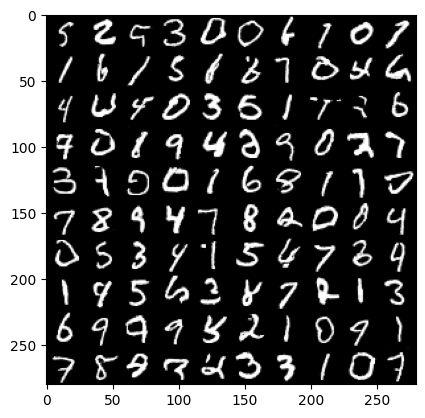

In [ ]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')